In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 0.1  # Rate of battery charge
        self.B_discharge_rate = -0.1  # Rate of battery discharge
        self.P_B_charge_rate = 0.2  # Rate of power battery charge
        self.P_B_discharge_rate = -0.2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, -1, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 2, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        self.soc_stress_history_1 = []
        self.soc_stress_history_2 = []

        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step]) -(grid_action)

        absolute_grid_power_required = np.abs(grid_power_required)
        
        #absolute_grid_power_required = np.clip(absolute_grid_power_required, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]*load_deferral
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        #emission_penalty = - ((grid_power_required)**2)
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (((grid_action)) * self.Cg_t[self.time_step-1])*75
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha*10 * np.maximum(0, 0.2 - self.state[0]) + self.beta *10 * np.maximum(0, self.state[0] - 1.8))
        power_battery_penalty = - (self.gamma * 10 * np.maximum(0, 0.2 - self.state[1]) + self.delta *10 * np.maximum(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral) * 10
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        self.soc_stress_history_1.append(SoC_stress_1)
        self.soc_stress_history_2.append(SoC_stress_2)

        


        total_reward =  battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + imbalance_penalty + load_deferral_penalty 
       # Provide a reward if grid_power_required is between -2 and 0
        #emission_penalty  +
        if np.all(grid_power_required <= 0):
            total_reward += 2

        if np.all(imbalance_penalty >= 0):
            total_reward += 20


            
        

        #print(f"emission:{emission_penalty}")
        #print(f"battery:{battery_penalty}")
        #print(f"power battery:{power_battery_penalty}")
        #print(f"SoC_stress_1:{SoC_stress_1}")
        #print(f"SoC_stress_2:{SoC_stress_2}")
        #print(f"imbalance_penalty:{imbalance_penalty}")
              
              
        
        
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


In [3]:
from stable_baselines3.common.callbacks import BaseCallback


class RewardTracker(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardTracker, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0  # Temporary holder for accumulating rewards

    def _on_step(self) -> bool:
        if 'rewards' in self.locals and 'dones' in self.locals:
            reward = self.locals['rewards'][0]
            done = self.locals['dones'][0]
            
            # Accumulate the reward
            self.current_episode_reward += reward
            
            if done:
                self.episode_rewards.append(self.current_episode_reward)
                self.current_episode_reward = 0  # Reset the accumulator
        return True


Using cpu device
Using cpu device
Training Battery Safety Controller...
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 88       |
|    time_elapsed    | 2        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 4.7      |
|    critic_loss     | 184      |
|    ent_coef        | 0.974    |
|    ent_coef_loss   | -0.164   |
|    learning_rate   | 0.0003   |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 56       |
|    time_elapsed    | 6        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 7.56     |
|    critic_loss     | 145      |
|    ent_coef        | 0.925    |
|    ent_coef_loss   | -0.359   |
|    learning_rate   | 0.0003   |
|    n_updates       | 283      |
----------

---------------------------------
| time/              |          |
|    episodes        | 76       |
|    fps             | 40       |
|    time_elapsed    | 90       |
|    total_timesteps | 3648     |
| train/             |          |
|    actor_loss      | 3.79     |
|    critic_loss     | 34.5     |
|    ent_coef        | 0.464    |
|    ent_coef_loss   | -0.965   |
|    learning_rate   | 0.0003   |
|    n_updates       | 3547     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 80       |
|    fps             | 40       |
|    time_elapsed    | 95       |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | 4.07     |
|    critic_loss     | 26.7     |
|    ent_coef        | 0.446    |
|    ent_coef_loss   | -1.29    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3739     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 148      |
|    fps             | 39       |
|    time_elapsed    | 180      |
|    total_timesteps | 7104     |
| train/             |          |
|    actor_loss      | -4.41    |
|    critic_loss     | 33.7     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | -0.00194 |
|    learning_rate   | 0.0003   |
|    n_updates       | 7003     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 152      |
|    fps             | 39       |
|    time_elapsed    | 185      |
|    total_timesteps | 7296     |
| train/             |          |
|    actor_loss      | -5.58    |
|    critic_loss     | 16.4     |
|    ent_coef        | 0.283    |
|    ent_coef_loss   | 0.126    |
|    learning_rate   | 0.0003   |
|    n_updates       | 7195     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 220      |
|    fps             | 38       |
|    time_elapsed    | 274      |
|    total_timesteps | 10560    |
| train/             |          |
|    actor_loss      | -10.5    |
|    critic_loss     | 23.3     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.126   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10459    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 224      |
|    fps             | 38       |
|    time_elapsed    | 279      |
|    total_timesteps | 10752    |
| train/             |          |
|    actor_loss      | -11.3    |
|    critic_loss     | 21.3     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | 0.0408   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10651    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 292      |
|    fps             | 37       |
|    time_elapsed    | 368      |
|    total_timesteps | 14016    |
| train/             |          |
|    actor_loss      | -15.6    |
|    critic_loss     | 25.1     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | 0.293    |
|    learning_rate   | 0.0003   |
|    n_updates       | 13915    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 296      |
|    fps             | 37       |
|    time_elapsed    | 374      |
|    total_timesteps | 14208    |
| train/             |          |
|    actor_loss      | -14.8    |
|    critic_loss     | 21.5     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | -0.467   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14107    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 364      |
|    fps             | 37       |
|    time_elapsed    | 465      |
|    total_timesteps | 17472    |
| train/             |          |
|    actor_loss      | -17.2    |
|    critic_loss     | 36.6     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | 0.114    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17371    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 368      |
|    fps             | 37       |
|    time_elapsed    | 471      |
|    total_timesteps | 17664    |
| train/             |          |
|    actor_loss      | -17.7    |
|    critic_loss     | 25.6     |
|    ent_coef        | 0.276    |
|    ent_coef_loss   | 0.0883   |
|    learning_rate   | 0.0003   |
|    n_updates       | 17563    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 436      |
|    fps             | 37       |
|    time_elapsed    | 562      |
|    total_timesteps | 20928    |
| train/             |          |
|    actor_loss      | -18.9    |
|    critic_loss     | 31.8     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | -0.154   |
|    learning_rate   | 0.0003   |
|    n_updates       | 20827    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 440      |
|    fps             | 37       |
|    time_elapsed    | 567      |
|    total_timesteps | 21120    |
| train/             |          |
|    actor_loss      | -18.9    |
|    critic_loss     | 22.7     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | 0.476    |
|    learning_rate   | 0.0003   |
|    n_updates       | 21019    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 508      |
|    fps             | 36       |
|    time_elapsed    | 659      |
|    total_timesteps | 24384    |
| train/             |          |
|    actor_loss      | -19.8    |
|    critic_loss     | 31.2     |
|    ent_coef        | 0.288    |
|    ent_coef_loss   | 0.278    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24283    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 512      |
|    fps             | 36       |
|    time_elapsed    | 665      |
|    total_timesteps | 24576    |
| train/             |          |
|    actor_loss      | -20.5    |
|    critic_loss     | 19.5     |
|    ent_coef        | 0.29     |
|    ent_coef_loss   | 0.113    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24475    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 580      |
|    fps             | 36       |
|    time_elapsed    | 756      |
|    total_timesteps | 27840    |
| train/             |          |
|    actor_loss      | -21      |
|    critic_loss     | 25.7     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | 0.115    |
|    learning_rate   | 0.0003   |
|    n_updates       | 27739    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 584      |
|    fps             | 36       |
|    time_elapsed    | 761      |
|    total_timesteps | 28032    |
| train/             |          |
|    actor_loss      | -20.5    |
|    critic_loss     | 17.1     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.171   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27931    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 652      |
|    fps             | 36       |
|    time_elapsed    | 853      |
|    total_timesteps | 31296    |
| train/             |          |
|    actor_loss      | -21.1    |
|    critic_loss     | 21.8     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.168   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31195    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 656      |
|    fps             | 36       |
|    time_elapsed    | 858      |
|    total_timesteps | 31488    |
| train/             |          |
|    actor_loss      | -21.3    |
|    critic_loss     | 22.6     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.212   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31387    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 724      |
|    fps             | 36       |
|    time_elapsed    | 952      |
|    total_timesteps | 34752    |
| train/             |          |
|    actor_loss      | -20.6    |
|    critic_loss     | 27.1     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.159   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34651    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 728      |
|    fps             | 36       |
|    time_elapsed    | 957      |
|    total_timesteps | 34944    |
| train/             |          |
|    actor_loss      | -21.5    |
|    critic_loss     | 15.1     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | 0.255    |
|    learning_rate   | 0.0003   |
|    n_updates       | 34843    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 796      |
|    fps             | 36       |
|    time_elapsed    | 1049     |
|    total_timesteps | 38208    |
| train/             |          |
|    actor_loss      | -21.6    |
|    critic_loss     | 30.2     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | -0.27    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38107    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 800      |
|    fps             | 36       |
|    time_elapsed    | 1054     |
|    total_timesteps | 38400    |
| train/             |          |
|    actor_loss      | -21.6    |
|    critic_loss     | 31.2     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | 0.508    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38299    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 868      |
|    fps             | 36       |
|    time_elapsed    | 1145     |
|    total_timesteps | 41664    |
| train/             |          |
|    actor_loss      | -21.9    |
|    critic_loss     | 31.6     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | 0.0963   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41563    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 872      |
|    fps             | 36       |
|    time_elapsed    | 1150     |
|    total_timesteps | 41856    |
| train/             |          |
|    actor_loss      | -22.2    |
|    critic_loss     | 10.5     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | -0.358   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41755    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 940      |
|    fps             | 36       |
|    time_elapsed    | 1233     |
|    total_timesteps | 45120    |
| train/             |          |
|    actor_loss      | -23.5    |
|    critic_loss     | 19.1     |
|    ent_coef        | 0.272    |
|    ent_coef_loss   | -0.693   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45019    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 944      |
|    fps             | 36       |
|    time_elapsed    | 1238     |
|    total_timesteps | 45312    |
| train/             |          |
|    actor_loss      | -22.9    |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.269    |
|    ent_coef_loss   | -0.499   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45211    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1012     |
|    fps             | 36       |
|    time_elapsed    | 1321     |
|    total_timesteps | 48576    |
| train/             |          |
|    actor_loss      | -23.6    |
|    critic_loss     | 30.2     |
|    ent_coef        | 0.265    |
|    ent_coef_loss   | 0.109    |
|    learning_rate   | 0.0003   |
|    n_updates       | 48475    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1016     |
|    fps             | 36       |
|    time_elapsed    | 1326     |
|    total_timesteps | 48768    |
| train/             |          |
|    actor_loss      | -23.6    |
|    critic_loss     | 36.7     |
|    ent_coef        | 0.271    |
|    ent_coef_loss   | 0.0648   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48667    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1084     |
|    fps             | 36       |
|    time_elapsed    | 1410     |
|    total_timesteps | 52032    |
| train/             |          |
|    actor_loss      | -23.8    |
|    critic_loss     | 25.9     |
|    ent_coef        | 0.275    |
|    ent_coef_loss   | -0.0183  |
|    learning_rate   | 0.0003   |
|    n_updates       | 51931    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1088     |
|    fps             | 36       |
|    time_elapsed    | 1415     |
|    total_timesteps | 52224    |
| train/             |          |
|    actor_loss      | -23.2    |
|    critic_loss     | 31.2     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | 0.00887  |
|    learning_rate   | 0.0003   |
|    n_updates       | 52123    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1156     |
|    fps             | 37       |
|    time_elapsed    | 1499     |
|    total_timesteps | 55488    |
| train/             |          |
|    actor_loss      | -24.6    |
|    critic_loss     | 35.2     |
|    ent_coef        | 0.268    |
|    ent_coef_loss   | 0.138    |
|    learning_rate   | 0.0003   |
|    n_updates       | 55387    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1160     |
|    fps             | 37       |
|    time_elapsed    | 1504     |
|    total_timesteps | 55680    |
| train/             |          |
|    actor_loss      | -24.3    |
|    critic_loss     | 36.4     |
|    ent_coef        | 0.267    |
|    ent_coef_loss   | -0.15    |
|    learning_rate   | 0.0003   |
|    n_updates       | 55579    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1228     |
|    fps             | 37       |
|    time_elapsed    | 1589     |
|    total_timesteps | 58944    |
| train/             |          |
|    actor_loss      | -24.5    |
|    critic_loss     | 32.7     |
|    ent_coef        | 0.271    |
|    ent_coef_loss   | -0.0398  |
|    learning_rate   | 0.0003   |
|    n_updates       | 58843    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1232     |
|    fps             | 37       |
|    time_elapsed    | 1594     |
|    total_timesteps | 59136    |
| train/             |          |
|    actor_loss      | -24.3    |
|    critic_loss     | 32.7     |
|    ent_coef        | 0.272    |
|    ent_coef_loss   | -0.0808  |
|    learning_rate   | 0.0003   |
|    n_updates       | 59035    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1300     |
|    fps             | 37       |
|    time_elapsed    | 1679     |
|    total_timesteps | 62400    |
| train/             |          |
|    actor_loss      | -23.5    |
|    critic_loss     | 42.4     |
|    ent_coef        | 0.272    |
|    ent_coef_loss   | -0.0244  |
|    learning_rate   | 0.0003   |
|    n_updates       | 62299    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1304     |
|    fps             | 37       |
|    time_elapsed    | 1684     |
|    total_timesteps | 62592    |
| train/             |          |
|    actor_loss      | -23.2    |
|    critic_loss     | 21.3     |
|    ent_coef        | 0.277    |
|    ent_coef_loss   | 0.227    |
|    learning_rate   | 0.0003   |
|    n_updates       | 62491    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1372     |
|    fps             | 37       |
|    time_elapsed    | 1770     |
|    total_timesteps | 65856    |
| train/             |          |
|    actor_loss      | -24.2    |
|    critic_loss     | 43.2     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | 0.0783   |
|    learning_rate   | 0.0003   |
|    n_updates       | 65755    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1376     |
|    fps             | 37       |
|    time_elapsed    | 1775     |
|    total_timesteps | 66048    |
| train/             |          |
|    actor_loss      | -23.9    |
|    critic_loss     | 33.6     |
|    ent_coef        | 0.278    |
|    ent_coef_loss   | -0.303   |
|    learning_rate   | 0.0003   |
|    n_updates       | 65947    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1444     |
|    fps             | 37       |
|    time_elapsed    | 1863     |
|    total_timesteps | 69312    |
| train/             |          |
|    actor_loss      | -23.7    |
|    critic_loss     | 35.7     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | 0.242    |
|    learning_rate   | 0.0003   |
|    n_updates       | 69211    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1448     |
|    fps             | 37       |
|    time_elapsed    | 1868     |
|    total_timesteps | 69504    |
| train/             |          |
|    actor_loss      | -23.2    |
|    critic_loss     | 25       |
|    ent_coef        | 0.277    |
|    ent_coef_loss   | -0.197   |
|    learning_rate   | 0.0003   |
|    n_updates       | 69403    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1516     |
|    fps             | 37       |
|    time_elapsed    | 1959     |
|    total_timesteps | 72768    |
| train/             |          |
|    actor_loss      | -23.3    |
|    critic_loss     | 22.9     |
|    ent_coef        | 0.271    |
|    ent_coef_loss   | -0.339   |
|    learning_rate   | 0.0003   |
|    n_updates       | 72667    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1520     |
|    fps             | 37       |
|    time_elapsed    | 1964     |
|    total_timesteps | 72960    |
| train/             |          |
|    actor_loss      | -23.3    |
|    critic_loss     | 37       |
|    ent_coef        | 0.275    |
|    ent_coef_loss   | 0.0879   |
|    learning_rate   | 0.0003   |
|    n_updates       | 72859    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1588     |
|    fps             | 37       |
|    time_elapsed    | 2055     |
|    total_timesteps | 76224    |
| train/             |          |
|    actor_loss      | -22.9    |
|    critic_loss     | 43.9     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -0.189   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76123    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1592     |
|    fps             | 37       |
|    time_elapsed    | 2061     |
|    total_timesteps | 76416    |
| train/             |          |
|    actor_loss      | -22.7    |
|    critic_loss     | 32.2     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.0705   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76315    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1660     |
|    fps             | 36       |
|    time_elapsed    | 2155     |
|    total_timesteps | 79680    |
| train/             |          |
|    actor_loss      | -24.3    |
|    critic_loss     | 39.6     |
|    ent_coef        | 0.278    |
|    ent_coef_loss   | 0.168    |
|    learning_rate   | 0.0003   |
|    n_updates       | 79579    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1664     |
|    fps             | 36       |
|    time_elapsed    | 2160     |
|    total_timesteps | 79872    |
| train/             |          |
|    actor_loss      | -23.7    |
|    critic_loss     | 28.4     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | -0.0448  |
|    learning_rate   | 0.0003   |
|    n_updates       | 79771    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1732     |
|    fps             | 36       |
|    time_elapsed    | 2252     |
|    total_timesteps | 83136    |
| train/             |          |
|    actor_loss      | -24.9    |
|    critic_loss     | 38.4     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | 0.0383   |
|    learning_rate   | 0.0003   |
|    n_updates       | 83035    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1736     |
|    fps             | 36       |
|    time_elapsed    | 2257     |
|    total_timesteps | 83328    |
| train/             |          |
|    actor_loss      | -25.3    |
|    critic_loss     | 20       |
|    ent_coef        | 0.278    |
|    ent_coef_loss   | 0.0945   |
|    learning_rate   | 0.0003   |
|    n_updates       | 83227    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1804     |
|    fps             | 36       |
|    time_elapsed    | 2349     |
|    total_timesteps | 86592    |
| train/             |          |
|    actor_loss      | -27.4    |
|    critic_loss     | 21.7     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | -0.151   |
|    learning_rate   | 0.0003   |
|    n_updates       | 86491    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1808     |
|    fps             | 36       |
|    time_elapsed    | 2355     |
|    total_timesteps | 86784    |
| train/             |          |
|    actor_loss      | -26.5    |
|    critic_loss     | 16.7     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | -0.11    |
|    learning_rate   | 0.0003   |
|    n_updates       | 86683    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1876     |
|    fps             | 36       |
|    time_elapsed    | 2447     |
|    total_timesteps | 90048    |
| train/             |          |
|    actor_loss      | -28.5    |
|    critic_loss     | 42.5     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.439   |
|    learning_rate   | 0.0003   |
|    n_updates       | 89947    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1880     |
|    fps             | 36       |
|    time_elapsed    | 2453     |
|    total_timesteps | 90240    |
| train/             |          |
|    actor_loss      | -28.2    |
|    critic_loss     | 32.9     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.314   |
|    learning_rate   | 0.0003   |
|    n_updates       | 90139    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1948     |
|    fps             | 36       |
|    time_elapsed    | 2547     |
|    total_timesteps | 93504    |
| train/             |          |
|    actor_loss      | -29.8    |
|    critic_loss     | 27.1     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.276   |
|    learning_rate   | 0.0003   |
|    n_updates       | 93403    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1952     |
|    fps             | 36       |
|    time_elapsed    | 2554     |
|    total_timesteps | 93696    |
| train/             |          |
|    actor_loss      | -29.5    |
|    critic_loss     | 36       |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.0349  |
|    learning_rate   | 0.0003   |
|    n_updates       | 93595    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2020     |
|    fps             | 36       |
|    time_elapsed    | 2647     |
|    total_timesteps | 96960    |
| train/             |          |
|    actor_loss      | -30.8    |
|    critic_loss     | 26.3     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | -0.27    |
|    learning_rate   | 0.0003   |
|    n_updates       | 96859    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2024     |
|    fps             | 36       |
|    time_elapsed    | 2652     |
|    total_timesteps | 97152    |
| train/             |          |
|    actor_loss      | -30.6    |
|    critic_loss     | 41.1     |
|    ent_coef        | 0.29     |
|    ent_coef_loss   | -0.258   |
|    learning_rate   | 0.0003   |
|    n_updates       | 97051    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 55       |
|    time_elapsed    | 10       |
|    total_timesteps | 576      |
| train/             |          |
|    actor_loss      | 8.5      |
|    critic_loss     | 99       |
|    ent_coef        | 0.886    |
|    ent_coef_loss   | -0.491   |
|    learning_rate   | 0.0003   |
|    n_updates       | 475      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 16       |
|    fps             | 52       |
|    time_elapsed    | 14       |
|    total_timesteps | 768      |
| train/             |          |
|    actor_loss      | 7.37     |
|    critic_loss     | 95.4     |
|    ent_coef        | 0.849    |
|    ent_coef_loss   | -0.577   |
|    learning_rate   | 0.0003   |
|    n_updates       | 667      |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 84       |
|    fps             | 41       |
|    time_elapsed    | 96       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 2.2      |
|    critic_loss     | 37.7     |
|    ent_coef        | 0.39     |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3931     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 88       |
|    fps             | 41       |
|    time_elapsed    | 101      |
|    total_timesteps | 4224     |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 23.1     |
|    ent_coef        | 0.376    |
|    ent_coef_loss   | -1.38    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4123     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 156      |
|    fps             | 40       |
|    time_elapsed    | 183      |
|    total_timesteps | 7488     |
| train/             |          |
|    actor_loss      | -6.79    |
|    critic_loss     | 33       |
|    ent_coef        | 0.268    |
|    ent_coef_loss   | -0.319   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7387     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 160      |
|    fps             | 40       |
|    time_elapsed    | 188      |
|    total_timesteps | 7680     |
| train/             |          |
|    actor_loss      | -8.29    |
|    critic_loss     | 17.7     |
|    ent_coef        | 0.262    |
|    ent_coef_loss   | -0.519   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7579     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 228      |
|    fps             | 40       |
|    time_elapsed    | 271      |
|    total_timesteps | 10944    |
| train/             |          |
|    actor_loss      | -13.5    |
|    critic_loss     | 32.1     |
|    ent_coef        | 0.277    |
|    ent_coef_loss   | -0.496   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10843    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 232      |
|    fps             | 40       |
|    time_elapsed    | 276      |
|    total_timesteps | 11136    |
| train/             |          |
|    actor_loss      | -12.4    |
|    critic_loss     | 30.6     |
|    ent_coef        | 0.281    |
|    ent_coef_loss   | -0.0991  |
|    learning_rate   | 0.0003   |
|    n_updates       | 11035    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 300      |
|    fps             | 40       |
|    time_elapsed    | 359      |
|    total_timesteps | 14400    |
| train/             |          |
|    actor_loss      | -16.1    |
|    critic_loss     | 30.4     |
|    ent_coef        | 0.255    |
|    ent_coef_loss   | -0.0728  |
|    learning_rate   | 0.0003   |
|    n_updates       | 14299    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 304      |
|    fps             | 40       |
|    time_elapsed    | 364      |
|    total_timesteps | 14592    |
| train/             |          |
|    actor_loss      | -16.1    |
|    critic_loss     | 28.5     |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | -0.125   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14491    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 372      |
|    fps             | 38       |
|    time_elapsed    | 459      |
|    total_timesteps | 17856    |
| train/             |          |
|    actor_loss      | -20.1    |
|    critic_loss     | 27.2     |
|    ent_coef        | 0.234    |
|    ent_coef_loss   | -0.0532  |
|    learning_rate   | 0.0003   |
|    n_updates       | 17755    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 376      |
|    fps             | 38       |
|    time_elapsed    | 464      |
|    total_timesteps | 18048    |
| train/             |          |
|    actor_loss      | -20.5    |
|    critic_loss     | 30.8     |
|    ent_coef        | 0.237    |
|    ent_coef_loss   | -0.0614  |
|    learning_rate   | 0.0003   |
|    n_updates       | 17947    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 444      |
|    fps             | 38       |
|    time_elapsed    | 547      |
|    total_timesteps | 21312    |
| train/             |          |
|    actor_loss      | -21.9    |
|    critic_loss     | 35.8     |
|    ent_coef        | 0.263    |
|    ent_coef_loss   | 0.634    |
|    learning_rate   | 0.0003   |
|    n_updates       | 21211    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 448      |
|    fps             | 38       |
|    time_elapsed    | 552      |
|    total_timesteps | 21504    |
| train/             |          |
|    actor_loss      | -21.6    |
|    critic_loss     | 27.8     |
|    ent_coef        | 0.262    |
|    ent_coef_loss   | -0.172   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21403    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 516      |
|    fps             | 38       |
|    time_elapsed    | 636      |
|    total_timesteps | 24768    |
| train/             |          |
|    actor_loss      | -21.4    |
|    critic_loss     | 24.6     |
|    ent_coef        | 0.251    |
|    ent_coef_loss   | -0.484   |
|    learning_rate   | 0.0003   |
|    n_updates       | 24667    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 520      |
|    fps             | 38       |
|    time_elapsed    | 641      |
|    total_timesteps | 24960    |
| train/             |          |
|    actor_loss      | -21.8    |
|    critic_loss     | 34       |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | -0.0374  |
|    learning_rate   | 0.0003   |
|    n_updates       | 24859    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 588      |
|    fps             | 38       |
|    time_elapsed    | 726      |
|    total_timesteps | 28224    |
| train/             |          |
|    actor_loss      | -23.1    |
|    critic_loss     | 37.6     |
|    ent_coef        | 0.243    |
|    ent_coef_loss   | 0.0573   |
|    learning_rate   | 0.0003   |
|    n_updates       | 28123    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 592      |
|    fps             | 38       |
|    time_elapsed    | 731      |
|    total_timesteps | 28416    |
| train/             |          |
|    actor_loss      | -23.2    |
|    critic_loss     | 24.9     |
|    ent_coef        | 0.24     |
|    ent_coef_loss   | 0.346    |
|    learning_rate   | 0.0003   |
|    n_updates       | 28315    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 660      |
|    fps             | 38       |
|    time_elapsed    | 819      |
|    total_timesteps | 31680    |
| train/             |          |
|    actor_loss      | -24      |
|    critic_loss     | 25.7     |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | 0.274    |
|    learning_rate   | 0.0003   |
|    n_updates       | 31579    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 664      |
|    fps             | 38       |
|    time_elapsed    | 824      |
|    total_timesteps | 31872    |
| train/             |          |
|    actor_loss      | -23.9    |
|    critic_loss     | 28.4     |
|    ent_coef        | 0.242    |
|    ent_coef_loss   | 0.00944  |
|    learning_rate   | 0.0003   |
|    n_updates       | 31771    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 732      |
|    fps             | 38       |
|    time_elapsed    | 910      |
|    total_timesteps | 35136    |
| train/             |          |
|    actor_loss      | -24.7    |
|    critic_loss     | 38.8     |
|    ent_coef        | 0.244    |
|    ent_coef_loss   | -0.0707  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35035    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 736      |
|    fps             | 38       |
|    time_elapsed    | 915      |
|    total_timesteps | 35328    |
| train/             |          |
|    actor_loss      | -23.7    |
|    critic_loss     | 35.9     |
|    ent_coef        | 0.243    |
|    ent_coef_loss   | -0.0732  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35227    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 804      |
|    fps             | 38       |
|    time_elapsed    | 997      |
|    total_timesteps | 38592    |
| train/             |          |
|    actor_loss      | -25      |
|    critic_loss     | 19       |
|    ent_coef        | 0.231    |
|    ent_coef_loss   | 0.308    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38491    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 808      |
|    fps             | 38       |
|    time_elapsed    | 1002     |
|    total_timesteps | 38784    |
| train/             |          |
|    actor_loss      | -25.1    |
|    critic_loss     | 26.1     |
|    ent_coef        | 0.232    |
|    ent_coef_loss   | 0.206    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38683    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 876      |
|    fps             | 38       |
|    time_elapsed    | 1085     |
|    total_timesteps | 42048    |
| train/             |          |
|    actor_loss      | -25.5    |
|    critic_loss     | 43       |
|    ent_coef        | 0.241    |
|    ent_coef_loss   | -0.179   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41947    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 880      |
|    fps             | 38       |
|    time_elapsed    | 1090     |
|    total_timesteps | 42240    |
| train/             |          |
|    actor_loss      | -26.2    |
|    critic_loss     | 29.7     |
|    ent_coef        | 0.238    |
|    ent_coef_loss   | 0.219    |
|    learning_rate   | 0.0003   |
|    n_updates       | 42139    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 948      |
|    fps             | 38       |
|    time_elapsed    | 1174     |
|    total_timesteps | 45504    |
| train/             |          |
|    actor_loss      | -25.8    |
|    critic_loss     | 25.3     |
|    ent_coef        | 0.237    |
|    ent_coef_loss   | 0.0546   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45403    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 952      |
|    fps             | 38       |
|    time_elapsed    | 1179     |
|    total_timesteps | 45696    |
| train/             |          |
|    actor_loss      | -25.1    |
|    critic_loss     | 34.8     |
|    ent_coef        | 0.244    |
|    ent_coef_loss   | -0.0928  |
|    learning_rate   | 0.0003   |
|    n_updates       | 45595    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1020     |
|    fps             | 38       |
|    time_elapsed    | 1263     |
|    total_timesteps | 48960    |
| train/             |          |
|    actor_loss      | -26      |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.246    |
|    ent_coef_loss   | -0.318   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48859    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1024     |
|    fps             | 38       |
|    time_elapsed    | 1268     |
|    total_timesteps | 49152    |
| train/             |          |
|    actor_loss      | -25.4    |
|    critic_loss     | 23.5     |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | 0.0235   |
|    learning_rate   | 0.0003   |
|    n_updates       | 49051    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1092     |
|    fps             | 38       |
|    time_elapsed    | 1353     |
|    total_timesteps | 52416    |
| train/             |          |
|    actor_loss      | -25.5    |
|    critic_loss     | 37.9     |
|    ent_coef        | 0.235    |
|    ent_coef_loss   | 0.407    |
|    learning_rate   | 0.0003   |
|    n_updates       | 52315    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1096     |
|    fps             | 38       |
|    time_elapsed    | 1358     |
|    total_timesteps | 52608    |
| train/             |          |
|    actor_loss      | -25.6    |
|    critic_loss     | 28.8     |
|    ent_coef        | 0.236    |
|    ent_coef_loss   | -0.129   |
|    learning_rate   | 0.0003   |
|    n_updates       | 52507    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1164     |
|    fps             | 38       |
|    time_elapsed    | 1444     |
|    total_timesteps | 55872    |
| train/             |          |
|    actor_loss      | -25.9    |
|    critic_loss     | 26.7     |
|    ent_coef        | 0.246    |
|    ent_coef_loss   | -0.394   |
|    learning_rate   | 0.0003   |
|    n_updates       | 55771    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1168     |
|    fps             | 38       |
|    time_elapsed    | 1449     |
|    total_timesteps | 56064    |
| train/             |          |
|    actor_loss      | -25.9    |
|    critic_loss     | 27.9     |
|    ent_coef        | 0.24     |
|    ent_coef_loss   | 0.165    |
|    learning_rate   | 0.0003   |
|    n_updates       | 55963    |
---------------------------------
----------------------------------
| time/      

---------------------------------
| time/              |          |
|    episodes        | 1236     |
|    fps             | 38       |
|    time_elapsed    | 1535     |
|    total_timesteps | 59328    |
| train/             |          |
|    actor_loss      | -26.3    |
|    critic_loss     | 19.3     |
|    ent_coef        | 0.247    |
|    ent_coef_loss   | -0.164   |
|    learning_rate   | 0.0003   |
|    n_updates       | 59227    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1240     |
|    fps             | 38       |
|    time_elapsed    | 1540     |
|    total_timesteps | 59520    |
| train/             |          |
|    actor_loss      | -26.6    |
|    critic_loss     | 33.4     |
|    ent_coef        | 0.251    |
|    ent_coef_loss   | 0.0211   |
|    learning_rate   | 0.0003   |
|    n_updates       | 59419    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1308     |
|    fps             | 38       |
|    time_elapsed    | 1626     |
|    total_timesteps | 62784    |
| train/             |          |
|    actor_loss      | -26.5    |
|    critic_loss     | 42.7     |
|    ent_coef        | 0.253    |
|    ent_coef_loss   | -0.0657  |
|    learning_rate   | 0.0003   |
|    n_updates       | 62683    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1312     |
|    fps             | 38       |
|    time_elapsed    | 1631     |
|    total_timesteps | 62976    |
| train/             |          |
|    actor_loss      | -26.7    |
|    critic_loss     | 33.9     |
|    ent_coef        | 0.246    |
|    ent_coef_loss   | 0.0894   |
|    learning_rate   | 0.0003   |
|    n_updates       | 62875    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1380     |
|    fps             | 38       |
|    time_elapsed    | 1719     |
|    total_timesteps | 66240    |
| train/             |          |
|    actor_loss      | -26.7    |
|    critic_loss     | 37.7     |
|    ent_coef        | 0.244    |
|    ent_coef_loss   | -0.167   |
|    learning_rate   | 0.0003   |
|    n_updates       | 66139    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1384     |
|    fps             | 38       |
|    time_elapsed    | 1724     |
|    total_timesteps | 66432    |
| train/             |          |
|    actor_loss      | -26.8    |
|    critic_loss     | 28.3     |
|    ent_coef        | 0.241    |
|    ent_coef_loss   | -0.218   |
|    learning_rate   | 0.0003   |
|    n_updates       | 66331    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1452     |
|    fps             | 38       |
|    time_elapsed    | 1812     |
|    total_timesteps | 69696    |
| train/             |          |
|    actor_loss      | -27.3    |
|    critic_loss     | 38.9     |
|    ent_coef        | 0.243    |
|    ent_coef_loss   | 0.354    |
|    learning_rate   | 0.0003   |
|    n_updates       | 69595    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1456     |
|    fps             | 38       |
|    time_elapsed    | 1817     |
|    total_timesteps | 69888    |
| train/             |          |
|    actor_loss      | -26.7    |
|    critic_loss     | 24.8     |
|    ent_coef        | 0.249    |
|    ent_coef_loss   | -0.0446  |
|    learning_rate   | 0.0003   |
|    n_updates       | 69787    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1524     |
|    fps             | 38       |
|    time_elapsed    | 1906     |
|    total_timesteps | 73152    |
| train/             |          |
|    actor_loss      | -27.6    |
|    critic_loss     | 38.4     |
|    ent_coef        | 0.254    |
|    ent_coef_loss   | 0.705    |
|    learning_rate   | 0.0003   |
|    n_updates       | 73051    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1528     |
|    fps             | 38       |
|    time_elapsed    | 1911     |
|    total_timesteps | 73344    |
| train/             |          |
|    actor_loss      | -27.3    |
|    critic_loss     | 46.6     |
|    ent_coef        | 0.256    |
|    ent_coef_loss   | -0.0141  |
|    learning_rate   | 0.0003   |
|    n_updates       | 73243    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1596     |
|    fps             | 38       |
|    time_elapsed    | 2000     |
|    total_timesteps | 76608    |
| train/             |          |
|    actor_loss      | -27.7    |
|    critic_loss     | 39.5     |
|    ent_coef        | 0.254    |
|    ent_coef_loss   | 0.0272   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76507    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1600     |
|    fps             | 38       |
|    time_elapsed    | 2005     |
|    total_timesteps | 76800    |
| train/             |          |
|    actor_loss      | -27.9    |
|    critic_loss     | 30.2     |
|    ent_coef        | 0.259    |
|    ent_coef_loss   | -0.186   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76699    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1668     |
|    fps             | 38       |
|    time_elapsed    | 2094     |
|    total_timesteps | 80064    |
| train/             |          |
|    actor_loss      | -27.9    |
|    critic_loss     | 24.3     |
|    ent_coef        | 0.257    |
|    ent_coef_loss   | -0.0166  |
|    learning_rate   | 0.0003   |
|    n_updates       | 79963    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1672     |
|    fps             | 38       |
|    time_elapsed    | 2099     |
|    total_timesteps | 80256    |
| train/             |          |
|    actor_loss      | -27.4    |
|    critic_loss     | 20.6     |
|    ent_coef        | 0.254    |
|    ent_coef_loss   | 0.261    |
|    learning_rate   | 0.0003   |
|    n_updates       | 80155    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1740     |
|    fps             | 38       |
|    time_elapsed    | 2188     |
|    total_timesteps | 83520    |
| train/             |          |
|    actor_loss      | -27.6    |
|    critic_loss     | 23.2     |
|    ent_coef        | 0.257    |
|    ent_coef_loss   | 0.0843   |
|    learning_rate   | 0.0003   |
|    n_updates       | 83419    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1744     |
|    fps             | 38       |
|    time_elapsed    | 2193     |
|    total_timesteps | 83712    |
| train/             |          |
|    actor_loss      | -27.2    |
|    critic_loss     | 24.3     |
|    ent_coef        | 0.261    |
|    ent_coef_loss   | 0.142    |
|    learning_rate   | 0.0003   |
|    n_updates       | 83611    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1812     |
|    fps             | 38       |
|    time_elapsed    | 2282     |
|    total_timesteps | 86976    |
| train/             |          |
|    actor_loss      | -28.2    |
|    critic_loss     | 31.3     |
|    ent_coef        | 0.25     |
|    ent_coef_loss   | -0.483   |
|    learning_rate   | 0.0003   |
|    n_updates       | 86875    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1816     |
|    fps             | 38       |
|    time_elapsed    | 2287     |
|    total_timesteps | 87168    |
| train/             |          |
|    actor_loss      | -27.6    |
|    critic_loss     | 30.1     |
|    ent_coef        | 0.249    |
|    ent_coef_loss   | 0.198    |
|    learning_rate   | 0.0003   |
|    n_updates       | 87067    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1884     |
|    fps             | 38       |
|    time_elapsed    | 2377     |
|    total_timesteps | 90432    |
| train/             |          |
|    actor_loss      | -28.3    |
|    critic_loss     | 39.5     |
|    ent_coef        | 0.269    |
|    ent_coef_loss   | -0.325   |
|    learning_rate   | 0.0003   |
|    n_updates       | 90331    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1888     |
|    fps             | 38       |
|    time_elapsed    | 2382     |
|    total_timesteps | 90624    |
| train/             |          |
|    actor_loss      | -27.5    |
|    critic_loss     | 21.1     |
|    ent_coef        | 0.265    |
|    ent_coef_loss   | 0.224    |
|    learning_rate   | 0.0003   |
|    n_updates       | 90523    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1956     |
|    fps             | 37       |
|    time_elapsed    | 2471     |
|    total_timesteps | 93888    |
| train/             |          |
|    actor_loss      | -27.4    |
|    critic_loss     | 53.1     |
|    ent_coef        | 0.271    |
|    ent_coef_loss   | -0.161   |
|    learning_rate   | 0.0003   |
|    n_updates       | 93787    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1960     |
|    fps             | 37       |
|    time_elapsed    | 2476     |
|    total_timesteps | 94080    |
| train/             |          |
|    actor_loss      | -28      |
|    critic_loss     | 21       |
|    ent_coef        | 0.273    |
|    ent_coef_loss   | 0.017    |
|    learning_rate   | 0.0003   |
|    n_updates       | 93979    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2028     |
|    fps             | 37       |
|    time_elapsed    | 2566     |
|    total_timesteps | 97344    |
| train/             |          |
|    actor_loss      | -27.4    |
|    critic_loss     | 29.4     |
|    ent_coef        | 0.262    |
|    ent_coef_loss   | -0.308   |
|    learning_rate   | 0.0003   |
|    n_updates       | 97243    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2032     |
|    fps             | 37       |
|    time_elapsed    | 2571     |
|    total_timesteps | 97536    |
| train/             |          |
|    actor_loss      | -27.7    |
|    critic_loss     | 43.9     |
|    ent_coef        | 0.261    |
|    ent_coef_loss   | -0.193   |
|    learning_rate   | 0.0003   |
|    n_updates       | 97435    |
---------------------------------
---------------------------------
| time/       

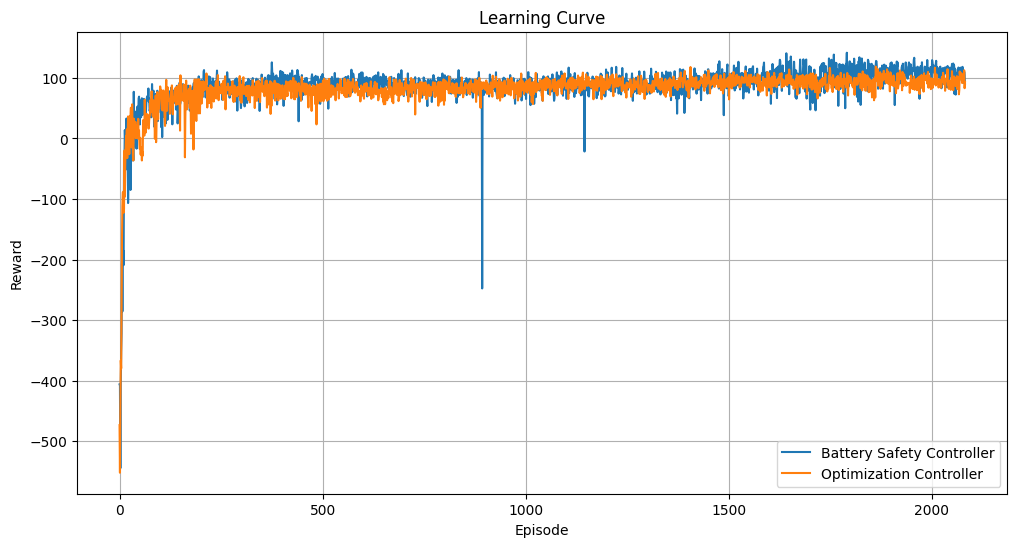

Mean reward for Battery Safety Controller: 87.34268072410036
Highest reward for Battery Safety Controller: 141.55160075426102
Mean reward for Optimization Controller: 81.2256440757742
Highest reward for Optimization Controller: 118.70272698998451
Total optimization time: 5373.311366319656 seconds
Episode Reward: [45.919823 58.820637  4.095037 60.39779 ]
Episode Reward: [ 52.014423 105.78028   19.089174 104.75264 ]
Episode Reward: [68.14044  42.709896 54.29757  54.700886]
Episode Reward: [ 2.9073637  -0.21125269  1.4837464   1.4146808 ]
Episode Reward: [45.814842 40.069332 22.077412 48.848335]
Episode Reward: [52.075718 65.785416 11.558034 72.76958 ]
Episode Reward: [12.148554   6.372511   7.3233237 11.397192 ]
Episode Reward: [81.17957  73.40378  26.192724 81.120544]
Episode Reward: [105.21385   87.034676  42.8103    84.274925]
Episode Reward: [-5.060787   -8.449507   -0.52151155 -5.3895226 ]
Episode Reward: [46.44225  68.11574   4.097453 68.84598 ]
Episode Reward: [45.416843  67.71209

In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import time
from stable_baselines3.common.callbacks import BaseCallback


start_time = time.time()




class BatterySafetyController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = SAC("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)
        
        
    def take_action(self, obs):
        obs_array = np.array(obs[0])  # Convert to NumPy array if it is not
        obs_array = obs_array.reshape(1, -1)  # Reshaping the array
        action, _ = self.model.predict(obs_array, deterministic=True)
        
        # Assuming `action` is a single value and creating a tuple with 4 elements
        # You will have to adjust the logic here to generate the correct four elements as per your requirement
        return (action[0], action[0], action[0], action[0])


class OptimizationController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = SAC("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)

    def take_action(self, obs):
        #print("Observation: ", obs)  # Print the observation to verify the fix
        obs_array = obs[0]  # Extracting the NumPy array from the tuple
        assert obs_array.shape[0] == 4, f"Invalid observation shape: {obs_array.shape}"
        action, _ = self.model.predict(obs_array, deterministic=True)
        return action
def ensure_battery_safety(env, battery_safety_controller, max_actions=10):
    total_reward = 0
    action_count = 0
    obs = env.reset()
    actions_taken = []  # Track actions taken during the episode
    while action_count < max_actions:
        action = battery_safety_controller.take_action(obs)
        actions_taken.append(action)  # Store action
        new_obs, reward, done, truncated, info = env.step(action)
        

        battery_penalty = - (env.alpha * np.maximum(0, 0.2 - obs[0][0]) + env.beta * np.maximum(0, obs[0][0] - 0.8))
        power_battery_penalty = - (env.gamma *np.maximum(0, 0.2 - obs[0][1]) + env.delta *np.maximum(0, obs[0][1] - 0.8))
        if battery_penalty == 0 and power_battery_penalty == 0:
            break

        total_reward += reward
        action_count += 1
        obs = new_obs

    return new_obs, total_reward, done, actions_taken  # return actions_taken


if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1
    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    
    battery_safety_controller = BatterySafetyController(env)
    optimization_controller = OptimizationController(env)

    battery_safety_reward_tracker = RewardTracker()
    print("Training Battery Safety Controller...")
    battery_safety_controller.model.learn(total_timesteps=100000, callback=battery_safety_reward_tracker)

    optimization_reward_tracker = RewardTracker()
    print("Training Optimization Controller...")
    optimization_controller.model.learn(total_timesteps=100000, callback=optimization_reward_tracker)
    
        # Plotting the learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(battery_safety_reward_tracker.episode_rewards, label="Battery Safety Controller")
    plt.plot(optimization_reward_tracker.episode_rewards, label="Optimization Controller")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the mean rewards and their highest values:
    print(f"Mean reward for Battery Safety Controller: {np.mean(battery_safety_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Battery Safety Controller: {np.max(battery_safety_reward_tracker.episode_rewards)}")

    print(f"Mean reward for Optimization Controller: {np.mean(optimization_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Optimization Controller: {np.max(optimization_reward_tracker.episode_rewards)}")
    

    end_time = time.time()
    print(f"Total optimization time: {end_time - start_time} seconds")


    total_rewards = []

    action_tracker = []  # To store actions taken during evaluation

    final_episode_actions = []  # To store actions from the final episode

    for i in range(50):
        obs = env.reset()
        done = False
        episode_reward = 0

        action_tracker = []  # Reset action tracker at the start of every episode

        # Ensure battery safety
        obs, reward, done, actions_safety = ensure_battery_safety(env, battery_safety_controller)
        action_tracker.extend(actions_safety)  # Add actions from safety routine
        episode_reward += reward

        # Once battery is safe, optimize other parameters
        while not done:
            action = optimization_controller.take_action(obs)
            action_tracker.append(action)  # Track the action
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            #env.render()

        if i == 49:  # If it's the final episode
            final_episode_actions = action_tracker

        total_rewards.append(episode_reward)
        print(f"Episode Reward: {episode_reward}")
        best_actions_last_iter = final_episode_actions  # Using final episode actions as an example, modify accordingly.
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")
